In [6]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
import scipy
cmap = cm.jet
import math

In [7]:
mouse_vector = [56165, 56166, 32363, 32364, 32365]
conditions_vector = ['RANDOM', 'OVERLAPPING','STABLE']
sessions_random = [4,1,1,0,2]
sessions_overlapping = [1,3,2,1,3]
sessions_stable = [2,0,0,2,0]

sessions = [sessions_random, sessions_overlapping, sessions_stable]

decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20 ### 100 means everything was aligned, 200 means it was also equalized
alignment_v = 3           ## alignment version
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version
registration_v = 0        ## registration version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                 ## value of resampling
period = int(6 * sf / re_sf)
period_resting = period *10

print(sessions)

[[4, 1, 1, 0, 2], [1, 3, 2, 1, 3], [2, 0, 0, 2, 0]]


In [8]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/scoring_time_vector/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/figures/population_analysis/'

In [10]:
distance_list = []   ## correlation matrix list that will contain all the correlation matrix of multiple mice
for session_type in range(len(sessions)):
    session_numbers = sessions[session_type]
    distance_list_mouse = []
    for mouse_number in range(len(mouse_vector)):
        mouse = mouse_vector[mouse_number]
        session = session_numbers[mouse_number]
        if session != 0:
            activity_list = []
            timeline_list = []
            behaviour_list = []
            day = 1
            for trial in [1,6,11,16,21]:
                file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                                      '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                                      f'{component_evaluation_v}' +  '.0.npy'

                ##load activity and timeline
                activity = np.load(file_directory + file_name_session_1)
                neural_activity1 = activity[1:,:]
                ## z-score neural activity
                neural_activity = sstats.zscore(neural_activity1)

                ##downsample neural activity
                resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                                    re_sf=re_sf)

                activity_list.append(resample_neural_activity_mean)

                time_file_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_1_v' + f'{decoding_v}' + '.4.' + f'{1}' + \
                                      '.' + f'{0}' + '_10.pkl'
                timeline_file = open(timeline_file_dir + time_file_session_1, 'rb')
                timeline_info = pickle.load(timeline_file)
                ##normalize neural activity
                timeline_1 = np.zeros(len(timeline_info) + 1)
                for i in range(len(timeline_info)):
                    timeline_1[i] = timeline_info[i][1]
                timeline_1[len(timeline_info)] = activity.shape[1]
                resample_timeline = timeline_1/re_sf

                timeline_list.append(resample_timeline)

                beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' +'_day_'+f'{day}'+'_event_' + f'{re_sf}' + '.npy'
                ## LOAD BEHAVIOUR
                behaviour = np.load(behaviour_dir + beh_file_name_1)
                #c = np.linspace(0, 20, len(behaviour))
                reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
                resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
                resample_timeline = timeline_1/re_sf

                behaviour_list.append(resample_beh1)
                day = day + 1
            # for each day creates a list that counts and saves times of different events.
            # We will consider events here as resting period, navigation periods and object exploration periods.
            # Later on will also consider different objects in the exploration periods

            events_day_list = []
            events_counter_day_list = []
            events_time_starts_day = []
            for day in range(len(behaviour_list)):
                events_list = []
                events_counter_list = []
                events_time_starts = []
                start_counter = 100
                counter = 0
                for i in range(behaviour_list[day].shape[0]):
                    if behaviour_list[day][i] != start_counter:
                        events_list.append(start_counter)
                        events_counter_list.append(counter)
                        events_time_starts.append(i)
                        start_counter = behaviour_list[day][i]
                        counter = 1
                    else:
                        counter = counter + 1
                events_day_list.append(events_list)
                events_counter_day_list.append(events_counter_list)
                events_time_starts_day.append(events_time_starts)

            # separte events belonging to each of the behavioural conditions

            behavioural_events_days_list = []
            conditions = [ 'Resting', 'Navigation', 'Object_exploration']

            for day in range(len(behaviour_list)):
                events = np.array(events_day_list[day])
                events[np.where(events>1)] = 2
                events_counter = np.array(events_counter_day_list[day])
                events_time = np.array(events_time_starts_day[day])

                object_list = []
                for target in [0,1,2]:
                    period1 = period
                    if target == 0:
                        period1 = period_resting
                    object_data = []
                    position_events = np.where(events == target)[0]
                    events_duration = events_counter[position_events]   # convert to seconds
                    time = events_time[position_events]
                    i = 0
                    for event in events_duration:
                        if event > period:
                            object_data.append(activity_list[day][:,time[i]:time[i]+period1])
                        i = i + 1
                    object_list.append(object_data)
                behavioural_events_days_list.append(object_list)

            population_vector = []
            for day in range(len(behaviour_list)):
                mean_over_trials_list = []
                for i in range(len(behavioural_events_days_list[day])):
                    mean_over_trials= np.mean(behavioural_events_days_list[day][i], axis= 0)
                    if mean_over_trials.shape:
                        mean_over_trials_list.append(np.mean(mean_over_trials,axis=1))#/np.max(np.mean(mean_over_trials,axis=1)))
                population_vector.append(mean_over_trials_list)

            ## compute null hypotesis for euclidean distance

            # we compute for each day a matrix containing all the activity
            matrix = []
            matrix_elements_size= []
            for day in range(len(behavioural_events_days_list)):
                matrix_list = []
                matrix_size = 0
                matrix_limits = []
                for i in range(len(behavioural_events_days_list[day])):
                    if behavioural_events_days_list[day][i]: 
                        period1 = period
                        if i == 0:
                            period1=period_resting
                        mean_over_trials =  np.mean(behavioural_events_days_list[day][i], axis= 0)            
                        matrix1 = np.zeros((len(mean_over_trials),period1*len(behavioural_events_days_list[day][i])))
                        for j in range(len(behavioural_events_days_list[day][i])):
                            matrix1[:,j*period1:(j+1)*period1] = behavioural_events_days_list[day][i][j]
                        matrix_list.append(matrix1)
                        matrix_limits.append([matrix_size, matrix_size + period1*len(behavioural_events_days_list[day][i])])
                        matrix_size = matrix_size + period*len(behavioural_events_days_list[day][i])
                auxiliar_matrix = np.zeros((len(mean_over_trials),matrix_size))
                for i in range(len(matrix_list)):
                    auxiliar_matrix[:,matrix_limits[i][0]:matrix_limits[i][1]] = matrix_list[i]
                matrix.append(auxiliar_matrix)
                matrix_elements_size.append(matrix_limits)

            ## compute euclidean distance matrix using normalization
            euclidean_distance_list = []
            for day in range(len(behaviour_list)-1):
                euclidean_distance = np.zeros((len(population_vector[day]),len(population_vector[day])))
                for i in range(len(population_vector[day])):
                    for j in range(len(population_vector[day])):
                        distance = np.linalg.norm(population_vector[day][i]-population_vector[day][j])
                        euclidean_distance[i,j]= distance  / population_vector[day][i].shape
                euclidean_distance_list.append(euclidean_distance)
            distance_list_mouse.append(euclidean_distance_list)
    distance_list.append(distance_list_mouse)

/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


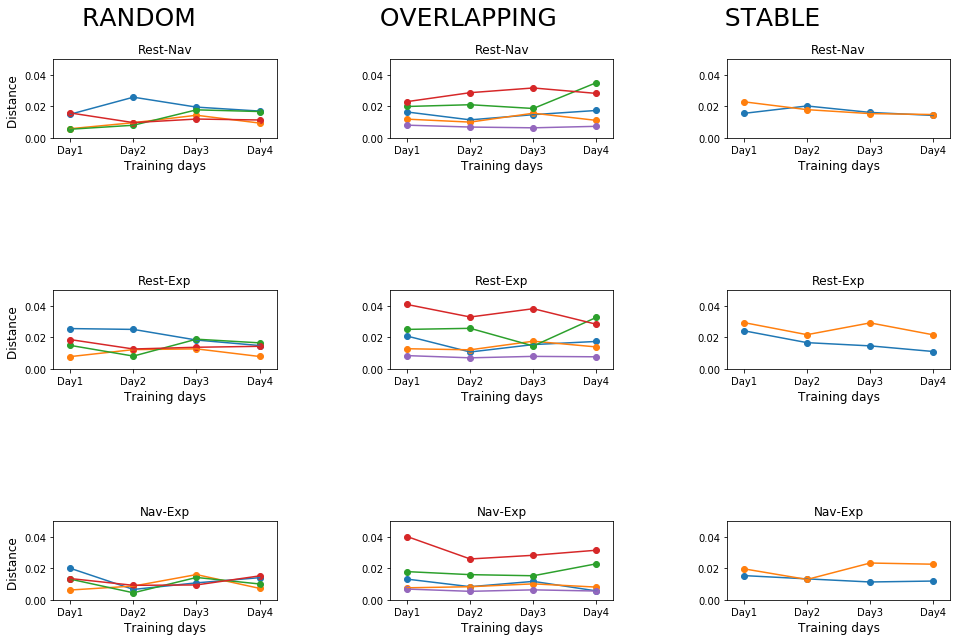

In [13]:
fig = plt.figure()
gs = plt.GridSpec(3,3)

condition_name = ['Rest-Nav','Rest-Exp','Nav-Exp']
x_axes = ['Day1', 'Day2', 'Day3', 'Day4']

evolution_list = []
for condition in range(3):
    for mouse in range(len(distance_list[condition])):
        evolution = np.zeros((4,3))
        for day in range(len(distance_list[condition][mouse])):
            evolution[day][0] = distance_list[condition][mouse][day][0,1]
            evolution[day][1] = distance_list[condition][mouse][day][0,2]
            evolution[day][2] = distance_list[condition][mouse][day][1,2]
        
        for i in range(3):
            ax = fig.add_subplot(gs[i,condition])
            ax.set_title(condition_name[i])
            if condition ==0:
                ax.set_ylabel('Distance ',fontsize = 12)
            ax.set_xlabel('Training days', fontsize = 12)
            x_pos = np.arange(1,5)
            ax.set_xticks(x_pos)
            ax.set_xticklabels(x_axes)
                            
            
            ax.plot([1,2,3,4],evolution[:,i])
            ax.scatter([1,2,3,4],evolution[:,i])
            
            ax.set_ylim([0, 0.05])

fig.tight_layout()
fig.set_size_inches(15,10)
fig.suptitle('RANDOM                       OVERLAPPING                     STABLE' , fontsize = 25)
figure_name = figure_path +'distance_evolution_events_all_mice'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)    

